<a href="https://colab.research.google.com/github/EuZx/Overview/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Mock_Sales_Data_Apr2017_Mar2024.xlsx to Mock_Sales_Data_Apr2017_Mar2024.xlsx


In [2]:
import gym
from gym import spaces
import numpy as np

class MarketingEnv(gym.Env):
    def __init__(self, data):
        super(MarketingEnv, self).__init__()
        self.data = data
        self.current_step = 0

        # Define action space: possible marketing spends
        self.action_space = spaces.Discrete(5)  # 5 discrete levels of marketing spend

        # Define observation space: state consists of normalized visitors and marketing spend
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        # Return the current state (normalized)
        obs = self.data.iloc[self.current_step]
        state = np.array([
            obs['Number of Visitors'] / 5000,
            obs['Total Gross Sales'] / 5000,
            obs['Marketing Spend'] / 10000
        ])
        return state

    def step(self, action):
        marketing_spend = action * 1000 + 1000  # Translate action to actual spend (e.g., $1000, $2000,...)
        current_data = self.data.iloc[self.current_step]

        # Calculate reward
        sales = current_data['Total Gross Sales']
        reward = sales - marketing_spend  # Profit as reward

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        next_state = self._next_observation() if not done else np.zeros(3)
        return next_state, reward, done, {}

    def render(self, mode='human'):
        # Optional: print out information at each step
        pass

In [3]:
import gym
import numpy as np
import pandas as pd

file_path = 'Mock_Sales_Data_Apr2017_Mar2024.xlsx'

data = pd.read_excel(file_path)
# Initialize the custom environment with the dataset
env = MarketingEnv(data=data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)

            # Calculate the target Q-value
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()

        # Predict the Q-values from the current state
            target_f = self.model(state)

        # Create the target Q-value tensor, identical to target_f but with the updated Q-value for the action taken
            target_values = target_f.clone().detach()
            target_values[0][action] = target

        # Perform a gradient descent step
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, target_values)
            loss.backward()
            self.optimizer.step()

    # Decay epsilon to reduce exploration over time
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Initialize the environment and agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
batch_size = 128
n_episodes = 100

for e in range(n_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(200):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"Episode: {e}/{n_episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

In [7]:
# Reset the environment to the initial state
state = env.reset()
state = np.reshape(state, [1, state_size])
final_decisions = []
total_reward = 0
done = False

# Run the agent in the environment to make decisions
while not done:
    action = agent.act(state)  # The agent decides on the action (e.g., marketing spend)
    final_decisions.append(action)  # Store the decision for later analysis
    next_state, reward, done, _ = env.step(action)  # Apply the action to the environment
    total_reward += reward  # Accumulate the total reward (e.g., total profit)
    state = np.reshape(next_state, [1, state_size])  # Move to the next state

# Print the final results
print("Final Decisions (Marketing Spend):", final_decisions)
print("Total Reward (Cumulative Profit):", total_reward)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Final Decisions (Marketing Spend): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

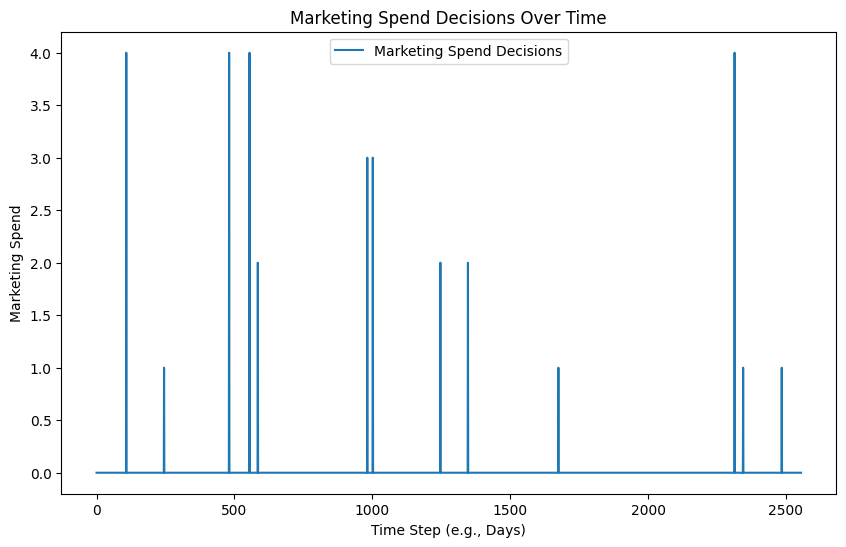

Baseline Reward: -2554695399.860002
Improvement over Baseline: 2555968000.000002


In [9]:
import matplotlib.pyplot as plt

# Visualize the decisions over time
plt.figure(figsize=(10, 6))
plt.plot(final_decisions, label="Marketing Spend Decisions")
plt.xlabel('Time Step (e.g., Days)')
plt.ylabel('Marketing Spend')
plt.title('Marketing Spend Decisions Over Time')
plt.legend()
plt.show()

def baseline_strategy(env, fixed_spend=1000):
    total_reward = 0
    state = env.reset()
    done = False

    while not done:
        action = fixed_spend  # Fixed marketing spend
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state

    return total_reward

# Optionally compare to baseline strategy
baseline_reward = baseline_strategy(env)  # Assuming a baseline strategy function
print(f"Baseline Reward: {baseline_reward}")
print(f"Improvement over Baseline: {total_reward - baseline_reward}")

In [10]:
# Example report generation
report = f"""
Final Marketing Spend Decisions Report
--------------------------------------

Total Cumulative Profit: {total_reward}
Baseline Profit: {baseline_reward}
Improvement Over Baseline: {total_reward - baseline_reward}

Marketing Spend Decisions:
{final_decisions}

Analysis:
- The agent recommended varying the marketing spend based on the expected visitor numbers and other factors.
- The total profit achieved using the RL-based decisions was higher than the baseline strategy.
- This suggests that the agent successfully learned to optimize marketing spend to maximize overall profit.

Recommendations:
- Consider implementing the RL-based marketing strategy in practice to potentially increase profits.
- Monitor and adjust the model as more data becomes available or as market conditions change.
"""

# Print or save the report
print(report)

# Optionally save the report to a file
with open('Marketing_Spend_Decision_Report.txt', 'w') as file:
    file.write(report)


Final Marketing Spend Decisions Report
--------------------------------------

Total Cumulative Profit: 1272600.1399999992
Baseline Profit: -2554695399.860002
Improvement Over Baseline: 2555968000.000002

Marketing Spend Decisions:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [11]:
# Example report generation
report = f"""
Final Marketing Spend Decisions Report
--------------------------------------

Total Cumulative Profit: {total_reward}
Baseline Profit: {baseline_reward}
Improvement Over Baseline: {total_reward - baseline_reward}

Marketing Spend Decisions:
{final_decisions}

Analysis:
- The agent recommended varying the marketing spend based on the expected visitor numbers and other factors.
- The total profit achieved using the RL-based decisions was higher than the baseline strategy.
- This suggests that the agent successfully learned to optimize marketing spend to maximize overall profit.

Recommendations:
- Consider implementing the RL-based marketing strategy in practice to potentially increase profits.
- Monitor and adjust the model as more data becomes available or as market conditions change.
"""

# Print or save the report
print(report)

# Optionally save the report to a file
with open('Marketing_Spend_Decision_Report.txt', 'w') as file:
    file.write(report)


Final Marketing Spend Decisions Report
--------------------------------------

Total Cumulative Profit: 1272600.1399999992
Baseline Profit: -2554695399.860002
Improvement Over Baseline: 2555968000.000002

Marketing Spend Decisions:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0